In [109]:
import pandas as pd
from collections import Counter
    

def get_ngrams(word, n):
    return list(zip(*[word[i:] for i in range(n)]))


def get_train_ngram_freqs(train_fn, n=3):
    freqs = Counter()
    with open(train_fn, "r") as f:
        for line in f:
            lem, msd, form = line.rstrip().split("\t")
            tris = set(get_ngrams(lem, n))
            tris = tris.union(set(get_ngrams(form, n)))
            freqs += Counter(tris)

    return freqs


def get_train_ngram_lemma_freqs(train_fn, n=3):
    freqs = Counter()
    with open(train_fn, "r") as f:
        for line in f:
            lem, msd, form = line.rstrip().split("\t")
            tris = set(get_ngrams(lem, n))
            freqs += Counter(tris)

    return freqs


def get_train_ngram_form_freqs(train_fn, n=3):
    freqs = Counter()
    with open(train_fn, "r") as f:
        for line in f:
            lem, msd, form = line.rstrip().split("\t")
            tris = set(get_ngrams(form, n))
            freqs += Counter(tris)

    return freqs


def get_trigram_freq_by_error(train_tri_freqs, pred_fn):
    """Counts number of dev examples containing a trigram, and number of
    incorrect examples containing that trigram"""
    dev_sample_counts = Counter()
    dev_sample_error_counts = Counter()
    with open(pred_fn, "r") as f:
        for line in f:
            lem, msd, form, pred = line.rstrip().split("\t")
            trigrams = set(get_trigrams(lem))
            trigrams = trigrams.union(set(get_trigrams(form)))
            for t in trigrams:
                dev_sample_counts[t] += 1
                if form != pred:
                    dev_sample_error_counts[t] += 1

    return {t: {
        "train_freq": train_tri_freqs[t],
        "dev_sample_counts": dev_sample_counts[t],
        "dev_sample_error_counts": dev_sample_error_counts[t],
    } for t in list(train_tri_freqs.keys()) + list(dev_sample_counts.keys())}



train_fn = "../../yoyodyne/data/sig-2023/deu.trn"
dec_pred_fn = "../../yoyodyne/2023_eval/deu_dev_postproc_dec_side_by_side.preds"
ed_pred_fn = "../../yoyodyne/2023_eval/deu_dev_postproc_ed_side_by_side.preds"
dec_df = pd.read_csv(dec_pred_fn, sep="\t", names=["lemma", "msd", "gold", "dec_pred"])
ed_df = pd.read_csv(ed_pred_fn, sep="\t", names=["lemma", "msd", "gold", "ed_pred"])[["ed_pred"]]
# tri_train_freqs = get_train_ngram_freqs(train_fn, n=3)
# all = get_trigram_freq_by_error(tri_train_freqs, pred_fn)
# df = pd.DataFrame(all).T
# df["error_rate"] = df["dev_sample_error_counts"] / df["dev_sample_counts"]
# df = df.fillna(-1)
# df.head()
all_preds = pd.merge(dec_df, ed_df, left_index=True, right_index=True)
all_preds

,lemma,msd,gold,dec_pred,ed_pred
0,Abmachung,N;ACC(PL),Abmachungen,Abmachtungen,Abmachungen
1,Abmachung,N;ACC(SG),Abmachung,Abachmung,Abmachung
2,Abmachung,N;DAT(PL),Abmachungen,Abachmungen,Abmachungen
3,Abmachung,N;DAT(SG),Abmachung,Abachmung,Abmachung
4,Abmachung,N;GEN(PL),Abmachungen,Abachmungen,Abmachungen
...,...,...,...,...,...
995,Ölfass,N;DAT(SG),Ölfass,Sflass,Nlöfss
996,Ölfass,N;GEN(PL),Ölfässer,Alasse,löfasse
997,Ölfass,N;GEN(SG),Ölfasses,Alasses,löfasses
998,Ölfass,N;NOM(PL),Ölfässer,Alasse,löfasse


In [110]:
train_lemma_tri_freqs = get_train_ngram_lemma_freqs(train_fn, n=3)
train_lemma_bi_freqs = get_train_ngram_lemma_freqs(train_fn, n=2)
train_lemma_uni_freqs = get_train_ngram_lemma_freqs(train_fn, n=1)

train_form_tri_freqs = get_train_ngram_form_freqs(train_fn, n=3)
train_form_bi_freqs = get_train_ngram_form_freqs(train_fn, n=2)
train_form_uni_freqs = get_train_ngram_form_freqs(train_fn, n=1)

In [111]:
import numpy as np

def set_min_freqs(df):
    df.loc[:, "min_lemma_trigram_freq"] = 0
    df.loc[:, "min_lemma_bigram_freq"] = 0
    df.loc[:, "min_lemma_unigram_freq"] = 0
    df.loc[:, "min_form_trigram_freq"] = 0
    df.loc[:, "min_form_bigram_freq"] = 0
    df.loc[:, "min_form_unigram_freq"] = 0
    df.loc[:, "min_ed_pred_unigram_freq"] = 0
    df.loc[:, "min_ed_pred_bigram_freq"] = 0
    df.loc[:, "min_ed_pred_trigram_freq"] = 0
    df.loc[:, "min_dec_pred_unigram_freq"] = 0
    df.loc[:, "min_dec_pred_bigram_freq"] = 0
    df.loc[:, "min_dec_pred_trigram_freq"] = 0
    for idx, row in df.iterrows():
        lemma_tris = get_ngrams(row["lemma"], 3)
        lemma_bis = get_ngrams(row["lemma"], 2)
        lemma_unis = get_ngrams(row["lemma"], 1)
        form_tris = get_ngrams(row["gold"], 3)
        form_bis = get_ngrams(row["gold"], 2)
        form_unis = get_ngrams(row["gold"], 1)
        ed_pred_unis = get_ngrams(row["ed_pred"], 1)
        ed_pred_bis = get_ngrams(row["ed_pred"], 2)
        ed_pred_tris = get_ngrams(row["ed_pred"], 3)
        dec_pred_unis = get_ngrams(row["dec_pred"], 1)
        dec_pred_bis = get_ngrams(row["dec_pred"], 2)
        dec_pred_tris = get_ngrams(row["dec_pred"], 3)

        df.at[idx, "min_lemma_trigram_freq"] = min([
            train_lemma_tri_freqs.get(t, 0) for t in lemma_tris
        ])
        df.at[idx, "min_lemma_bigram_freq"] = min([
            train_lemma_bi_freqs.get(t, 0) for t in lemma_bis
        ])
        df.at[idx, "min_lemma_unigram_freq"] = min([
            train_lemma_uni_freqs.get(t, 0) for t in lemma_unis
        ])
        df.at[idx, "min_form_trigram_freq"] = min([
            train_form_tri_freqs.get(t, 0) for t in form_tris
        ])
        df.at[idx, "min_form_bigram_freq"] = min([
            train_form_bi_freqs.get(t, 0) for t in form_bis
        ])
        df.at[idx, "min_form_unigram_freq"] = min([
            train_form_uni_freqs.get(t, 0) for t in form_unis
        ])
        # Avgs
        df.at[idx, "avglemma_trigram_freq"] = np.mean([
            train_lemma_tri_freqs.get(t, 0) for t in lemma_tris
        ])
        df.at[idx, "avglemma_bigram_freq"] = np.mean([
            train_lemma_bi_freqs.get(t, 0) for t in lemma_bis
        ])
        df.at[idx, "avglemma_unigram_freq"] = np.mean([
            train_lemma_uni_freqs.get(t, 0) for t in lemma_unis
        ])
        df.at[idx, "avgform_trigram_freq"] = np.mean([
        train_form_tri_freqs.get(t, 0) for t in form_tris
        ])
        df.at[idx, "avgform_bigram_freq"] = np.mean([
            train_form_bi_freqs.get(t, 0) for t in form_bis
        ])
        df.at[idx, "avgform_unigram_freq"] = np.mean([
            train_form_uni_freqs.get(t, 0) for t in form_unis
        ])
        # Preds
        df.at[idx, "min_ed_pred_unigram_freq"] = min([
            train_form_uni_freqs.get(t, 0) for t in ed_pred_unis
        ])
        df.at[idx, "min_ed_pred_bigram_freq"] = min([
            train_form_bi_freqs.get(t, 0) for t in ed_pred_bis
        ])
        df.at[idx, "min_ed_pred_trigram_freq"] = min([
            train_form_tri_freqs.get(t, 0) for t in ed_pred_tris
        ])
        df.at[idx, "min_dec_pred_unigram_freq"] = min([
            train_form_uni_freqs.get(t, 0) for t in dec_pred_unis
        ])
        df.at[idx, "min_dec_pred_bigram_freq"] = min([
            train_form_bi_freqs.get(t, 0) for t in dec_pred_bis
        ])
        df.at[idx, "min_dec_pred_trigram_freq"] = min([
            train_form_tri_freqs.get(t, 0) for t in dec_pred_tris
        ])
        # Avgs
        df.at[idx, "avged_pred_unigram_freq"] = np.mean([
            train_form_uni_freqs.get(t, 0) for t in ed_pred_unis
        ])
        df.at[idx, "avged_pred_bigram_freq"] = np.mean([
            train_form_bi_freqs.get(t, 0) for t in ed_pred_bis
        ])
        df.at[idx, "avged_pred_trigram_freq"] = np.mean([
            train_form_tri_freqs.get(t, 0) for t in ed_pred_tris
        ])
        df.at[idx, "avgdec_pred_unigram_freq"] = np.mean([
            train_form_uni_freqs.get(t, 0) for t in dec_pred_unis
        ])
        df.at[idx, "avgdec_pred_bigram_freq"] = np.mean([
            train_form_bi_freqs.get(t, 0) for t in dec_pred_bis
        ])
        df.at[idx, "avgdec_pred_trigram_freq"] = np.mean([
            train_form_tri_freqs.get(t, 0) for t in dec_pred_tris
        ])

set_min_freqs(all_preds)
all_preds = all_preds.fillna(0)

In [113]:
# all_preds.loc[
#     (all_preds["ed_pred"] != all_preds["gold"]) &
#     (all_preds["dec_pred"] != all_preds["gold"]) &
#     (all_preds["ed_pred"] != all_preds["dec_pred"])
# ]
# Samples they both got wrong.
both_wrong = all_preds.loc[
    (all_preds["ed_pred"] != all_preds["gold"]) &
    (all_preds["dec_pred"] != all_preds["gold"])
]
print(set(both_wrong["msd"]))
both_wrong

{'V.PTCP;PST', 'V;IND;PRS;NOM(2,SG)', 'V;SBJV;PST;NOM(2,PL)', 'V;IND;PST;NOM(3,PL)', 'N;GEN(PL)', 'V;IND;PRS;NOM(1,PL)', 'V;IND;PST;NOM(2,PL)', 'N;NOM(SG)', 'V;SBJV;PST;NOM(1,SG)', 'V;SBJV;PST;NOM(1,PL)', 'V;SBJV;PRS;NOM(2,SG)', 'N;DAT(PL)', 'V;SBJV;PST;NOM(3,SG)', 'V;IND;PRS;NOM(3,SG)', 'V;IND;PST;NOM(1,PL)', 'V;IND;PST;NOM(3,SG)', 'N;GEN(SG)', 'V;SBJV;PRS;NOM(3,SG)', 'V.PTCP;PRS', 'V;SBJV;PRS;NOM(1,SG)', 'N;NOM(PL)', 'V;IND;PST;NOM(1,SG)', 'V;SBJV;PRS;NOM(1,PL)', 'N;DAT(SG)', 'V;IMP;NOM(2,PL)', 'N;ACC(SG)', 'V;IND;PST;NOM(2,SG)', 'V;NFIN', 'V;SBJV;PRS;NOM(2,PL)', 'V;SBJV;PRS;NOM(3,PL)', 'N;ACC(PL)', 'V;IMP;NOM(2,SG)', 'V;SBJV;PST;NOM(3,PL)', 'V;IND;PRS;NOM(2,PL)', 'V;IND;PRS;NOM(1,SG)', 'V;SBJV;PST;NOM(2,SG)', 'V;IND;PRS;NOM(3,PL)'}


,lemma,msd,gold,dec_pred,ed_pred,min_lemma_trigram_freq,min_lemma_bigram_freq,min_lemma_unigram_freq,min_form_trigram_freq,min_form_bigram_freq,...,avglemma_unigram_freq,avgform_trigram_freq,avgform_bigram_freq,avgform_unigram_freq,avged_pred_unigram_freq,avged_pred_bigram_freq,avged_pred_trigram_freq,avgdec_pred_unigram_freq,avgdec_pred_bigram_freq,avgdec_pred_trigram_freq
12,Abstieg,N;ACC(PL),Abstiege,Abstigen,Abstiegen,8,63,401,8,63,...,3737.428571,100.166667,873.428571,4945.250000,5025.111111,1212.625000,139.142857,4475.750000,1061.571429,132.833333
16,Abstieg,N;GEN(PL),Abstiege,Abestigen,Abstiegen,8,63,401,8,63,...,3737.428571,100.166667,873.428571,4945.250000,5025.111111,1212.625000,139.142857,5025.111111,1204.250000,246.428571
17,Abstieg,N;GEN(SG),Abstiegs,Abeitstigs,Abstieg,8,63,401,8,63,...,3737.428571,85.333333,748.571429,4325.500000,4306.000000,859.333333,100.200000,4639.700000,631.888889,75.000000
18,Abstieg,N;NOM(PL),Abstiege,Abstigen,Abstiegen,8,63,401,8,63,...,3737.428571,100.166667,873.428571,4945.250000,5025.111111,1212.625000,139.142857,4475.750000,1061.571429,132.833333
36,Assyriologin,N;ACC(PL),Assyriologinnen,Asologinnen,Asyriologinnen,0,8,236,0,8,...,3517.750000,29.769231,492.285714,4120.200000,4095.785714,502.769231,31.583333,4159.909091,576.700000,42.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ölfass,N;DAT(SG),Ölfass,Sflass,Nlöfss,0,0,0,0,0,...,2649.333333,24.750000,151.800000,2900.833333,2388.500000,90.600000,0.000000,2966.000000,214.000000,45.500000
996,Ölfass,N;GEN(PL),Ölfässer,Alasse,löfasse,0,0,0,0,0,...,2649.333333,47.666667,795.428571,3817.500000,3875.000000,211.000000,50.600000,4295.500000,294.400000,79.750000
997,Ölfass,N;GEN(SG),Ölfasses,Alasses,löfasses,0,0,0,0,0,...,2649.333333,51.833333,359.714286,3910.875000,3948.375000,359.142857,47.500000,4319.285714,453.333333,70.200000
998,Ölfass,N;NOM(PL),Ölfässer,Alasse,löfasse,0,0,0,0,0,...,2649.333333,47.666667,795.428571,3817.500000,3875.000000,211.000000,50.600000,4295.500000,294.400000,79.750000


In [114]:
# Samples they both got wrong, and guessed the same
all_preds.loc[
    (all_preds["ed_pred"] != all_preds["gold"]) &
    (all_preds["dec_pred"] != all_preds["gold"]) &
    (all_preds["ed_pred"] == all_preds["dec_pred"]) 
]

,lemma,msd,gold,dec_pred,ed_pred,min_lemma_trigram_freq,min_lemma_bigram_freq,min_lemma_unigram_freq,min_form_trigram_freq,min_form_bigram_freq,...,avglemma_unigram_freq,avgform_trigram_freq,avgform_bigram_freq,avgform_unigram_freq,avged_pred_unigram_freq,avged_pred_bigram_freq,avged_pred_trigram_freq,avgdec_pred_unigram_freq,avgdec_pred_bigram_freq,avgdec_pred_trigram_freq
214,Macher,N;NOM(PL),Macher,Machern,Machern,0,42,168,0,42,...,4099.833333,178.0,1478.2,4095.500000,4319.571429,1278.500000,193.40,4319.571429,1278.500000,193.40
302,Snack,N;DAT(PL),Snacks,Snacken,Snacken,0,0,391,0,0,...,3258.000000,9.0,111.4,2951.166667,4047.000000,742.000000,43.60,4047.000000,742.000000,43.60
304,Snack,N;GEN(PL),Snacks,Snacke,Snacke,0,0,391,0,0,...,3258.000000,9.0,111.4,2951.166667,3777.500000,173.000000,28.75,3777.500000,173.000000,28.75
305,Snack,N;GEN(SG),Snacks,Snackes,Snackes,0,0,391,0,0,...,3258.000000,9.0,111.4,2951.166667,3875.285714,352.166667,25.20,3875.285714,352.166667,25.20
306,Snack,N;NOM(PL),Snacks,Snacke,Snacke,0,0,391,0,0,...,3258.000000,9.0,111.4,2951.166667,3777.500000,173.000000,28.75,3777.500000,173.000000,28.75


<AxesSubplot:ylabel='min_lemma_trigram_freq'>

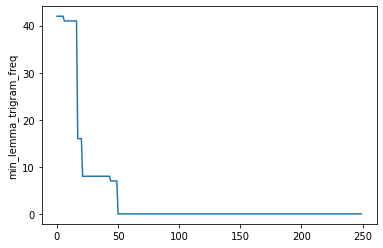

In [115]:
import seaborn as sns

both_wrong = both_wrong.sort_values("min_lemma_trigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=both_wrong,
    x=both_wrong.index,
    y="min_lemma_trigram_freq"
)

<AxesSubplot:ylabel='min_form_trigram_freq'>

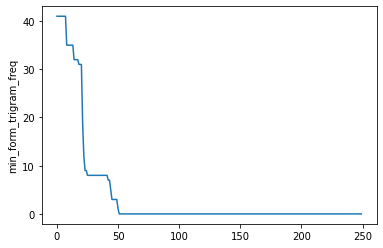

In [116]:
both_wrong = both_wrong.sort_values("min_form_trigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=both_wrong,
    x=both_wrong.index,
    y="min_form_trigram_freq"
)

In [117]:
only_dec_wrong = all_preds.loc[
    (all_preds["ed_pred"] == all_preds["gold"]) &
    (all_preds["dec_pred"] != all_preds["gold"])
]
print(set(only_dec_wrong["msd"]))
only_dec_wrong

{'V.PTCP;PST', 'V;IND;PRS;NOM(2,SG)', 'V;SBJV;PST;NOM(2,PL)', 'V;IND;PST;NOM(3,PL)', 'N;GEN(PL)', 'V;IND;PRS;NOM(1,PL)', 'V;IND;PST;NOM(2,PL)', 'N;NOM(SG)', 'V;SBJV;PST;NOM(1,SG)', 'V;SBJV;PST;NOM(1,PL)', 'V;SBJV;PRS;NOM(2,SG)', 'N;DAT(PL)', 'V;SBJV;PST;NOM(3,SG)', 'V;IND;PRS;NOM(3,SG)', 'V;IND;PST;NOM(1,PL)', 'V;IND;PST;NOM(3,SG)', 'N;GEN(SG)', 'V.PTCP;PRS', 'V;SBJV;PRS;NOM(3,SG)', 'V;SBJV;PRS;NOM(1,SG)', 'N;NOM(PL)', 'V;IND;PST;NOM(1,SG)', 'V;SBJV;PRS;NOM(1,PL)', 'N;DAT(SG)', 'V;IMP;NOM(2,PL)', 'N;ACC(SG)', 'V;NFIN', 'V;IND;PST;NOM(2,SG)', 'V;SBJV;PRS;NOM(2,PL)', 'V;SBJV;PRS;NOM(3,PL)', 'N;ACC(PL)', 'V;IMP;NOM(2,SG)', 'V;SBJV;PST;NOM(3,PL)', 'V;IND;PRS;NOM(1,SG)', 'V;IND;PRS;NOM(2,PL)', 'V;SBJV;PST;NOM(2,SG)', 'V;IND;PRS;NOM(3,PL)'}


,lemma,msd,gold,dec_pred,ed_pred,min_lemma_trigram_freq,min_lemma_bigram_freq,min_lemma_unigram_freq,min_form_trigram_freq,min_form_bigram_freq,...,avglemma_unigram_freq,avgform_trigram_freq,avgform_bigram_freq,avgform_unigram_freq,avged_pred_unigram_freq,avged_pred_bigram_freq,avged_pred_trigram_freq,avgdec_pred_unigram_freq,avgdec_pred_bigram_freq,avgdec_pred_trigram_freq
0,Abmachung,N;ACC(PL),Abmachungen,Abmachtungen,Abmachungen,0,0,401,0,0,...,2891.888889,125.333333,818.100000,3463.090909,3463.090909,818.100000,125.333333,3738.250000,785.454545,152.400000
1,Abmachung,N;ACC(SG),Abmachung,Abachmung,Abmachung,0,0,401,0,0,...,2891.888889,67.857143,454.500000,2556.666667,2556.666667,454.500000,67.857143,2556.666667,445.125000,80.428571
2,Abmachung,N;DAT(PL),Abmachungen,Abachmungen,Abmachungen,0,0,401,0,0,...,2891.888889,125.333333,818.100000,3463.090909,3463.090909,818.100000,125.333333,3463.090909,810.600000,135.111111
3,Abmachung,N;DAT(SG),Abmachung,Abachmung,Abmachung,0,0,401,0,0,...,2891.888889,67.857143,454.500000,2556.666667,2556.666667,454.500000,67.857143,2556.666667,445.125000,80.428571
4,Abmachung,N;GEN(PL),Abmachungen,Abachmungen,Abmachungen,0,0,401,0,0,...,2891.888889,125.333333,818.100000,3463.090909,3463.090909,818.100000,125.333333,3463.090909,810.600000,135.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,zerstören,"V;SBJV;PST;NOM(1,PL)",zerstörten,zörsten,zerstörten,0,0,267,0,0,...,5398.777778,387.500000,1826.666667,5643.900000,5643.900000,1826.666667,387.500000,4848.000000,1653.000000,355.000000
988,zerstören,"V;SBJV;PST;NOM(1,SG)",zerstörte,zörnterte,zerstörte,0,0,267,0,0,...,5398.777778,270.428571,1606.625000,5641.666667,5641.666667,1606.625000,270.428571,5775.222222,1841.125000,439.857143
989,zerstören,"V;SBJV;PST;NOM(2,PL)",zerstörtet,zörstet,zerstörtet,0,0,267,0,0,...,5398.777778,324.375000,1578.000000,5754.000000,5754.000000,1578.000000,324.375000,5005.285714,1280.000000,254.000000
990,zerstören,"V;SBJV;PST;NOM(2,SG)",zerstörtest,zörstertest,zerstörtest,0,0,267,0,0,...,5398.777778,352.444444,1591.000000,5636.545455,5636.545455,1591.000000,352.444444,5636.545455,1934.100000,514.777778


<AxesSubplot:ylabel='min_lemma_trigram_freq'>

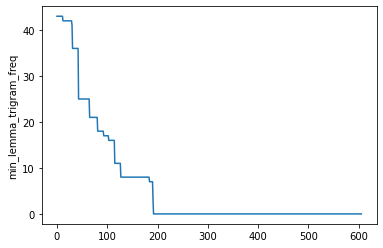

In [118]:
only_dec_wrong = only_dec_wrong.sort_values("min_lemma_trigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=only_dec_wrong,
    x=only_dec_wrong.index,
    y="min_lemma_trigram_freq"
)

<AxesSubplot:ylabel='min_form_trigram_freq'>

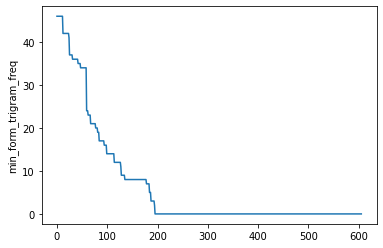

In [119]:
only_dec_wrong = only_dec_wrong.sort_values("min_form_trigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=only_dec_wrong,
    x=only_dec_wrong.index,
    y="min_form_trigram_freq"
)

In [120]:
only_dec_right = all_preds.loc[
    (all_preds["ed_pred"] != all_preds["gold"]) &
    (all_preds["dec_pred"] == all_preds["gold"])
]
print(set(only_dec_right["msd"]))
only_dec_right

set()


,lemma,msd,gold,dec_pred,ed_pred,min_lemma_trigram_freq,min_lemma_bigram_freq,min_lemma_unigram_freq,min_form_trigram_freq,min_form_bigram_freq,...,avglemma_unigram_freq,avgform_trigram_freq,avgform_bigram_freq,avgform_unigram_freq,avged_pred_unigram_freq,avged_pred_bigram_freq,avged_pred_trigram_freq,avgdec_pred_unigram_freq,avgdec_pred_bigram_freq,avgdec_pred_trigram_freq


In [121]:
both_right = all_preds.loc[
    (all_preds["ed_pred"] == all_preds["gold"]) &
    (all_preds["dec_pred"] == all_preds["gold"])
]
print(set(both_right["msd"]))
both_right

{'V.PTCP;PST', 'V;IND;PRS;NOM(2,SG)', 'V;SBJV;PST;NOM(2,PL)', 'V;IND;PST;NOM(3,PL)', 'N;GEN(PL)', 'V;IND;PRS;NOM(1,PL)', 'V;IND;PST;NOM(2,PL)', 'N;NOM(SG)', 'V;SBJV;PST;NOM(1,SG)', 'V;SBJV;PST;NOM(1,PL)', 'V;SBJV;PRS;NOM(2,SG)', 'N;DAT(PL)', 'V;SBJV;PST;NOM(3,SG)', 'V;IND;PRS;NOM(3,SG)', 'V;IND;PST;NOM(1,PL)', 'V;IND;PST;NOM(3,SG)', 'N;GEN(SG)', 'V;SBJV;PRS;NOM(3,SG)', 'V.PTCP;PRS', 'V;SBJV;PRS;NOM(1,SG)', 'N;NOM(PL)', 'V;IND;PST;NOM(1,SG)', 'V;SBJV;PRS;NOM(1,PL)', 'N;DAT(SG)', 'V;IMP;NOM(2,PL)', 'N;ACC(SG)', 'V;NFIN', 'V;IND;PST;NOM(2,SG)', 'V;SBJV;PRS;NOM(2,PL)', 'V;SBJV;PRS;NOM(3,PL)', 'N;ACC(PL)', 'V;IMP;NOM(2,SG)', 'V;SBJV;PST;NOM(3,PL)', 'V;IND;PRS;NOM(2,PL)', 'V;IND;PRS;NOM(1,SG)', 'V;SBJV;PST;NOM(2,SG)', 'V;IND;PRS;NOM(3,PL)'}


,lemma,msd,gold,dec_pred,ed_pred,min_lemma_trigram_freq,min_lemma_bigram_freq,min_lemma_unigram_freq,min_form_trigram_freq,min_form_bigram_freq,...,avglemma_unigram_freq,avgform_trigram_freq,avgform_bigram_freq,avgform_unigram_freq,avged_pred_unigram_freq,avged_pred_bigram_freq,avged_pred_trigram_freq,avgdec_pred_unigram_freq,avgdec_pred_bigram_freq,avgdec_pred_trigram_freq
8,Abschaum,N;ACC(SG),Abschaum,Abschaum,Abschaum,8,63,401,8,63,...,2380.500000,199.833333,569.714286,2461.750000,2461.750000,569.714286,199.833333,2461.750000,569.714286,199.833333
9,Abschaum,N;DAT(SG),Abschaum,Abschaum,Abschaum,8,63,401,8,63,...,2380.500000,199.833333,569.714286,2461.750000,2461.750000,569.714286,199.833333,2461.750000,569.714286,199.833333
10,Abschaum,N;GEN(SG),Abschaumes,Abschaumes,Abschaumes,8,63,401,8,63,...,2380.500000,161.625000,636.888889,3357.600000,3357.600000,636.888889,161.625000,3357.600000,636.888889,161.625000
11,Abschaum,N;NOM(SG),Abschaum,Abschaum,Abschaum,8,63,401,8,63,...,2380.500000,199.833333,569.714286,2461.750000,2461.750000,569.714286,199.833333,2461.750000,569.714286,199.833333
209,Macher,N;ACC(SG),Macher,Macher,Macher,0,42,168,0,42,...,4099.833333,178.000000,1478.200000,4095.500000,4095.500000,1478.200000,178.000000,4095.500000,1478.200000,178.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,zappen,"V;SBJV;PRS;NOM(2,SG)",zappest,zappest,zappest,0,12,1007,0,12,...,4207.500000,179.200000,590.666667,3976.000000,3976.000000,590.666667,179.200000,3976.000000,590.666667,179.200000
964,zappen,"V;SBJV;PRS;NOM(3,SG)",zappe,zappe,zappe,0,12,1007,0,12,...,4207.500000,29.666667,121.750000,3321.000000,3321.000000,121.750000,29.666667,3321.000000,121.750000,29.666667
965,zappen,"V;SBJV;PST;NOM(1,PL)",zappten,zappten,zappten,0,12,1007,0,12,...,4207.500000,267.200000,1286.666667,4147.714286,4147.714286,1286.666667,267.200000,4147.714286,1286.666667,267.200000
966,zappen,"V;SBJV;PST;NOM(2,SG)",zapptest,zapptest,zapptest,0,12,1007,0,12,...,4207.500000,234.666667,1027.142857,4324.625000,4324.625000,1027.142857,234.666667,4324.625000,1027.142857,234.666667


<AxesSubplot:ylabel='min_lemma_trigram_freq'>

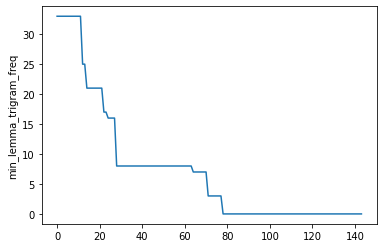

In [122]:
both_right = both_right.sort_values("min_lemma_trigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=both_right,
    x=both_right.index,
    y="min_lemma_trigram_freq"
)

<AxesSubplot:ylabel='min_form_trigram_freq'>

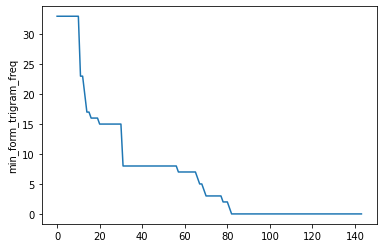

In [123]:
both_right = both_right.sort_values("min_form_trigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=both_right,
    x=both_right.index,
    y="min_form_trigram_freq"
)

<AxesSubplot:ylabel='min_lemma_unigram_freq'>

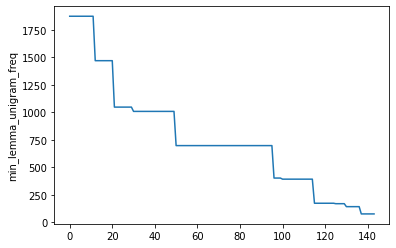

In [124]:
both_right = both_right.sort_values("min_lemma_unigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=both_right,
    x=both_right.index,
    y="min_lemma_unigram_freq"
)

<AxesSubplot:ylabel='min_lemma_unigram_freq'>

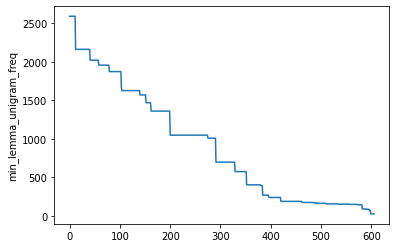

In [125]:
only_dec_wrong = only_dec_wrong.sort_values("min_lemma_unigram_freq", ascending=False).reset_index(drop=True)
sns.lineplot(
    data=only_dec_wrong,
    x=only_dec_wrong.index,
    y="min_lemma_unigram_freq"
)

<AxesSubplot:ylabel='min_form_trigram_freq'>

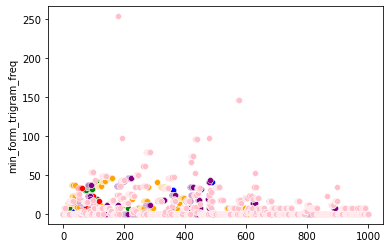

In [126]:
all_preds = all_preds.sort_values("lemma", ascending=False).reset_index(drop=True)
both_wrong = both_wrong.sort_values("lemma", ascending=False).reset_index(drop=True)
only_dec_wrong = only_dec_wrong.sort_values("lemma", ascending=False).reset_index(drop=True)
both_right = both_right.sort_values("lemma", ascending=False).reset_index(drop=True)
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_form_trigram_freq",
    color="blue"
)
sns.scatterplot(
    data=both_wrong,
    x=both_wrong.index,
    y="min_form_trigram_freq",
    color="green"
)
sns.scatterplot(
    data=only_dec_wrong,
    x=only_dec_wrong.index,
    y="min_form_trigram_freq",
    color="orange"
)
sns.scatterplot(
    data=both_right,
    x=both_right.index,
    y="min_form_trigram_freq",
    color="red"
)
# all_preds = all_preds.sort_values("min_ed_pred_trigram_freq", ascending=False).reset_index(drop=True)
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_ed_pred_trigram_freq",
    color="purple"
)
# all_preds = all_preds.sort_values("min_dec_pred_trigram_freq", ascending=False).reset_index(drop=True)
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_dec_pred_trigram_freq",
    color="pink"
)

<AxesSubplot:ylabel='min_ed_pred_trigram_freq'>

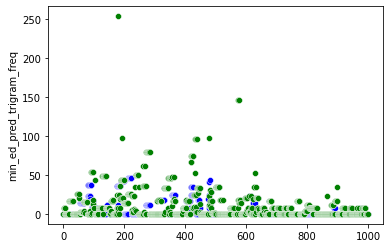

In [127]:
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_ed_pred_trigram_freq",
    color="blue"
)
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_dec_pred_trigram_freq",
    color="green"
)

<AxesSubplot:ylabel='min_ed_pred_trigram_freq'>

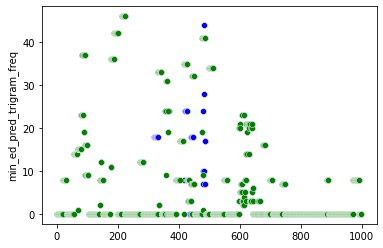

In [128]:
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_ed_pred_trigram_freq",
    color="blue"
)
sns.scatterplot(
    data=all_preds,
    x=all_preds.index,
    y="min_form_trigram_freq",
    color="green"
)

<AxesSubplot:ylabel='min_ed_pred_trigram_freq'>

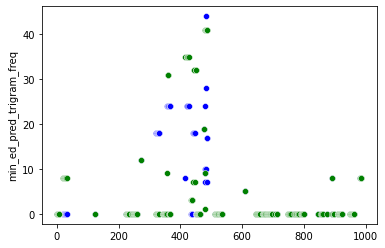

In [129]:
ed_wrong = all_preds.loc[all_preds["ed_pred"] != all_preds["gold"]]
sns.scatterplot(
    data=ed_wrong,
    x=ed_wrong.index,
    y="min_ed_pred_trigram_freq",
    color="blue"
)
sns.scatterplot(
    data=ed_wrong,
    x=ed_wrong.index,
    y="min_form_trigram_freq",
    color="green"
)

<AxesSubplot:ylabel='min_dec_pred_trigram_freq'>

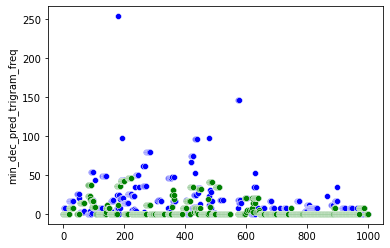

In [130]:
dec_wrong = all_preds.loc[all_preds["dec_pred"] != all_preds["gold"]]
sns.scatterplot(
    data=dec_wrong,
    x=dec_wrong.index,
    y="min_dec_pred_trigram_freq",
    color="blue"
)
sns.scatterplot(
    data=dec_wrong,
    x=dec_wrong.index,
    y="min_form_trigram_freq",
    color="green"
)

In [143]:
d = [{
    "All gold": all_preds["min_form_trigram_freq"].mean(),
    "Both wrong gold": both_wrong["min_form_trigram_freq"].mean(),
    "Dec wrong; ed right gold": only_dec_wrong["min_form_trigram_freq"].mean(),
    "Both right gold": both_right["min_form_trigram_freq"].mean(),
    "ED pred": all_preds["min_ed_pred_trigram_freq"].mean(),
    "Dec pred": all_preds["min_dec_pred_trigram_freq"].mean(),
}]
min_means_df = pd.DataFrame(d)
min_means_df

,All gold,Both wrong gold,Dec wrong; ed right gold,Both right gold,ED pred,Dec pred
0,5.939,3.916,6.511551,7.041667,5.817,10.302


In [137]:
{
    "Avg_trigram_freq_ed_preds": all_preds["avged_pred_trigram_freq"].mean(),
    "Avg_trigram_freq_dec_preds": all_preds["avgdec_pred_trigram_freq"].mean(),
    "Avg_trigram_freq_gold": all_preds["avgform_trigram_freq"].mean(),
    "Avg_trigram_freq_ed_wrong_gold": ed_wrong["avgform_trigram_freq"].mean(),
    "Avg_trigram_freq_ed_wrong_pred": ed_wrong["avged_pred_trigram_freq"].mean(),
    "Avg_trigram_freq_dec_wrong_gold": dec_wrong["avgform_trigram_freq"].mean(),
    "Avg_trigram_freq_dec_wrong_pred": dec_wrong["avgdec_pred_trigram_freq"].mean()
}

{'Avg_trigram_freq_ed_preds': 218.04604003679927,
 'Avg_trigram_freq_dec_preds': 231.0534735929104,
 'Avg_trigram_freq_gold': 215.99156966330023,
 'Avg_trigram_freq_ed_wrong_gold': 152.76060473822704,
 'Avg_trigram_freq_ed_wrong_pred': 160.97848623222322,
 'Avg_trigram_freq_dec_wrong_gold': 217.96667320175564,
 'Avg_trigram_freq_dec_wrong_pred': 235.56235536251515}

In [138]:
{
    "Avg_unigram_freq_ed_preds": all_preds["avged_pred_unigram_freq"].mean(),
    "Avg_unigram_freq_dec_preds": all_preds["avgdec_pred_unigram_freq"].mean(),
    "Avg_unigram_freq_gold": all_preds["avgform_unigram_freq"].mean(),
    "Avg_unigram_freq_ed_wrong_gold": ed_wrong["avgform_unigram_freq"].mean(),
    "Avg_unigram_freq_ed_wrong_pred": ed_wrong["avged_pred_unigram_freq"].mean(),
    "Avg_unigram_freq_dec_wrong_gold": dec_wrong["avgform_unigram_freq"].mean(),
    "Avg_unigram_freq_dec_wrong_pred": dec_wrong["avgdec_pred_unigram_freq"].mean()
}

{'Avg_unigram_freq_ed_preds': 4863.998807625792,
 'Avg_unigram_freq_dec_preds': 4933.115125538248,
 'Avg_unigram_freq_gold': 4862.6347585469875,
 'Avg_unigram_freq_ed_wrong_gold': 4718.314119395551,
 'Avg_unigram_freq_ed_wrong_pred': 4723.770315710768,
 'Avg_unigram_freq_dec_wrong_gold': 4919.353096536745,
 'Avg_unigram_freq_dec_wrong_pred': 5001.6899738629845}